# Model building

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics import r2_score 
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

## 1. Asset loading

### 1.1. Feature information

In [2]:
with open('../data/biometric_features.pkl', 'rb') as input_file:
    biometric_features=pickle.load(input_file)

with open('../data/input_features.pkl', 'rb') as input_file:
    input_features=pickle.load(input_file)

with open('../data/output_features.pkl', 'rb') as input_file:
    output_features=pickle.load(input_file)

with open('../data/categorical_features.pkl', 'rb') as input_file:
    categorical_features=pickle.load(input_file)

### 1.2. Datasets

In [3]:
with open('../data/processed/train.pkl', 'rb') as input_file:
    train_df=pickle.load(input_file)

with open('../data/processed/test.pkl', 'rb') as input_file:
    test_df=pickle.load(input_file)

## 2. Model Building

We need to build two models - one to predict time and the other to predict calories. We will again use a dictionary to keep things organized.

### 2.1. Model dictionary definition

In [4]:
# Instead of using HistGradientBoostingRegressor for both models, Im assigning RandomForestRegressor to calorie_model while keeping Gradient Boosting for time_model.

models={
    'calorie_model': RandomForestRegressor(n_estimators=100, random_state=42), # Using RF for calorie prediction
    'time_model': HistGradientBoostingRegressor(early_stopping=True) # Keeping HGB for duration prediction
}

### 2.2. Naive model cross validation

In [5]:
# Since Im comparing Random Forest Regression (calorie_model) and HistGradientBoostingRegressor (time_model), I'll use cross-validation to test their performance before hyperparameter tuning.
# Ensures models perform well across different data subsets
# Provides a baseline RMSE before tuning hyperparameters
# Helps compare effectiveness of Random Forest vs. Gradient Boosting before optimization

cross_val_results={}

for model_name, model in models.items():
    X_train = train_df[input_features[model_name]]
    y_train = train_df[output_features[model_name]]

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

    cross_val_results[model_name] = abs(scores.mean())

    print(f"{model_name} Naïve Cross-Validation RMSE: {cross_val_results[model_name]:.2f}")

    # Your code here... Remember: the features names for each model are the biometric
    # features + the 'extra' feature from the input features dictionary we
    # loaded above. The label name is also stored in the output features dictionary.
    # The keys match across the models, input features and output features dictionaries.

calorie_model Naïve Cross-Validation RMSE: 267.55
time_model Naïve Cross-Validation RMSE: 31.96


In [6]:
# Train calorie_model
models["calorie_model"].fit(train_df[input_features["calorie_model"]], train_df[output_features["calorie_model"]])

# Train time_model
models["time_model"].fit(train_df[input_features["time_model"]], train_df[output_features["time_model"]])

HistGradientBoostingRegressor(early_stopping=True)

In [7]:
# Since I can't directly extract feature_importances_, I can use permutation_importance from sklearn.inspection, which evaluates how much each feature affects model performance

def get_boosted_feature_importance(model, X_test, y_test, feature_names):
    """Uses permutation importance for HistGradientBoostingRegressor."""
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)

    return importance_df

# Apply function for time_model
time_feature_importance = get_boosted_feature_importance(
    models["time_model"], 
    test_df[input_features["time_model"]], 
    test_df[output_features["time_model"]], 
    input_features["time_model"]
)

print("Time Model Feature Importance:\n", time_feature_importance)

Time Model Feature Importance:
                Feature  Importance
2               Gender    0.001022
7  Mood Before Workout   -0.000094
3          Height (cm)   -0.000677
5         Workout Type   -0.000740
4          Weight (kg)   -0.000782
6          Sleep Hours   -0.001094
1                  Age   -0.001140
0      Calories Burned   -0.001789


In [8]:
# Identifies which biometric features impact predictions most.
# decide which inputs to keep vs. remove for streamlined training.

def get_feature_importance(model, feature_names):
    """Retrieves and sorts feature importance scores."""
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    return importance_df

# Checking importance for calorie_model (Random Forest)
calorie_feature_importance = get_feature_importance(models["calorie_model"], input_features["calorie_model"])
print("Calorie Model Feature Importance:\n", calorie_feature_importance)

Calorie Model Feature Importance:
                    Feature  Importance
0  Workout Duration (mins)    0.185791
6              Sleep Hours    0.172008
4              Weight (kg)    0.164652
3              Height (cm)    0.162240
1                      Age    0.148118
5             Workout Type    0.073013
7      Mood Before Workout    0.053615
2                   Gender    0.040562


In [9]:
# Since we previously used OrdinalEncoder, we need to validate if One-Hot Encoding (OHE) would be better for categorical features.
# Ordinal works well for ordered categories (e.g., Workout Intensity), but One-Hot is better for independent categories (e.g., Workout Type).

# Define mapping for Gender
gender_mapping = {0.0: "Male", 1.0: "Female", 2.0: "Other"}
train_df["Gender"] = train_df["Gender"].map(gender_mapping)
test_df["Gender"] = test_df["Gender"].map(gender_mapping)

# Define mapping for Workout Type
workout_mapping = {
    0.0: "Running", 1.0: "Cycling", 2.0: "Yoga", 
    3.0: "Swimming", 4.0: "Strength Training", 5.0: "HIIT"
}
train_df["Workout Type"] = train_df["Workout Type"].map(workout_mapping)
test_df["Workout Type"] = test_df["Workout Type"].map(workout_mapping)

encoder = OneHotEncoder(sparse_output=False)  # Use correct parameter
encoded_array = encoder.fit_transform(train_df[["Gender", "Workout Type"]])

# Retrieve meaningful feature names
encoded_feature_names = encoder.get_feature_names_out(["Gender", "Workout Type"])

# Convert to DataFrame with proper column names
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names)

# Merge back into dataset
train_df = train_df.drop(columns=["Gender", "Workout Type"]).join(encoded_df)
test_df = test_df.drop(columns=["Gender", "Workout Type"]).join(pd.DataFrame(encoder.transform(test_df[["Gender", "Workout Type"]]), columns=encoded_feature_names))

In [10]:
# Get updated categorical feature names
categorical_features = ["Gender_Female", "Gender_Male", "Gender_Other",
                        "Workout Type_Cycling", "Workout Type_HIIT", "Workout Type_Running",
                        "Workout Type_Strength Training", "Workout Type_Swimming", "Workout Type_Yoga"]

# Update calorie_model input features
input_features["calorie_model"] = [f for f in input_features["calorie_model"] if f not in ["Gender", "Workout Type"]] + categorical_features

# Update time_model input features
input_features["time_model"] = [f for f in input_features["time_model"] if f not in ["Gender", "Workout Type"]] + categorical_features

In [11]:
# Since models like Gradient Boosting perform better with scaled features, we should normalize values like age, weight, and resting heart rate.

# Define numeric features to scale
numeric_features = ["Age", "Height (cm)", "Weight (kg)", "Sleep Hours", "Resting Heart Rate (bpm)", "Body Fat (%)"]

# Apply StandardScaler
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

In [12]:
print(train_df.columns)

Index(['User ID', 'Age', 'Height (cm)', 'Weight (kg)',
       'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)',
       'Steps Taken', 'Distance (km)', 'Workout Intensity', 'Sleep Hours',
       'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'Gender_Female',
       'Gender_Male', 'Gender_Other', 'Workout Type_Cycling',
       'Workout Type_HIIT', 'Workout Type_Running',
       'Workout Type_Strength Training', 'Workout Type_Swimming',
       'Workout Type_Yoga'],
      dtype='object')


## 3. Model optimization

In [13]:
hyperparameters={
    "calorie_model": {
        "n_estimators": randint(50, 500),
        "max_depth": randint(3, 30),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "max_features": ["sqrt", "log2", None]
    },
    "time_model": {
        'max_iter': randint(10, 10000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 15),
        'l2_regularization': uniform(0.0, 0.5)
    }
    # etc.
}
optimized_hyperparameters={}

for model_name, model in models.items():
    search = RandomizedSearchCV(model, hyperparameters[model_name], n_iter=200, cv=5, scoring="neg_root_mean_squared_error", random_state=42)
    search.fit(train_df[input_features[model_name]], train_df[output_features[model_name]])

    models[model_name] = search.best_estimator_
    optimized_hyperparameters[model_name] = search.best_params_

    print(f"{model_name} Best Hyperparameters:\n", optimized_hyperparameters[model_name])

    # Your code here... HistGradientBoostingRegressor is fast on this dataset, so use
    # RandomizedSearchCV with a few hundred or thousand iterations. Make sure to replace
    # the naive model with the optimized one in the models dictionary and store the
    # winning hyperparameters using the model name as key in the optimized hyperparameters
    # dictionary.

calorie_model Best Hyperparameters:
 {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 10, 'n_estimators': 308}
time_model Best Hyperparameters:
 {'l2_regularization': np.float64(0.022609335053094703), 'learning_rate': np.float64(0.015273394899450402), 'max_depth': 3, 'max_iter': 2203}


In [14]:
def evaluate_model(model, test_df, model_name):
    """Evaluates RMSE for a given model."""
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False) if hasattr(mean_squared_error, 'squared') else mean_squared_error(y_test, y_pred) ** 0.5
  # Root Mean Squared Error
    
    print(f"{model_name} RMSE Before Tuning: {rmse:.2f}")
    return rmse

# Evaluate pre-tuned models
pre_tuned_rmse = {}
for model_name, model in models.items():
    pre_tuned_rmse[model_name] = evaluate_model(model, test_df, model_name)

calorie_model RMSE Before Tuning: 262.25
time_model RMSE Before Tuning: 31.86


In [15]:
# Retrain models with optimized hyperparameters
for model_name, model in models.items():
    model.fit(train_df[input_features[model_name]], train_df[output_features[model_name]])

# Evaluate post-tuned models
post_tuned_rmse = {}
for model_name, model in models.items():
    post_tuned_rmse[model_name] = evaluate_model(model, test_df, model_name)

calorie_model RMSE Before Tuning: 262.25
time_model RMSE Before Tuning: 31.85


In [16]:
# Print RMSE comparison
for model_name in models.keys():
    print(f"{model_name} Improvement: {pre_tuned_rmse[model_name]:.2f} → {post_tuned_rmse[model_name]:.2f}")

calorie_model Improvement: 262.25 → 262.25
time_model Improvement: 31.86 → 31.85


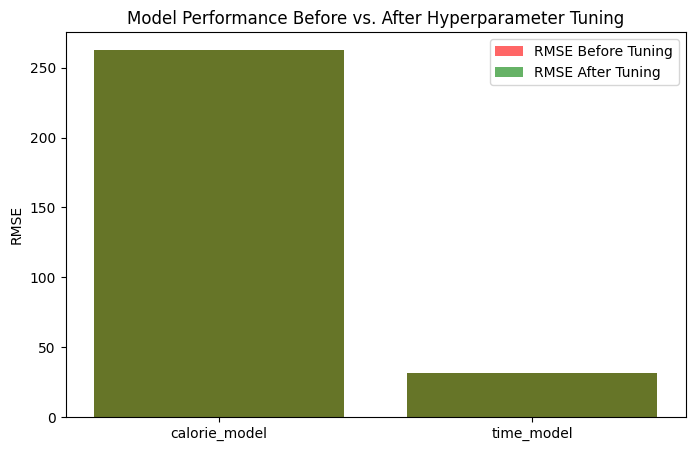

In [17]:
# Data for plotting
models_list = list(models.keys())  # ["calorie_model", "time_model"]
rmse_before = [pre_tuned_rmse[model] for model in models_list]
rmse_after = [post_tuned_rmse[model] for model in models_list]

# Create bar chart comparison
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(models_list, rmse_before, color='red', alpha=0.6, label="RMSE Before Tuning")
ax.bar(models_list, rmse_after, color='green', alpha=0.6, label="RMSE After Tuning")

# Labels & formatting
ax.set_ylabel("RMSE")
ax.set_title("Model Performance Before vs. After Hyperparameter Tuning")
ax.legend()
plt.show()

## 4. Model evaluation

In [18]:
# Your code here... Make predictions on the test set with the optimized time and calorie models.
# Then evaluate those predictions - plotting predicted vs true values and/or fit residuals is
# a good idea, you also probably want to look at the RMSE between predictions and labels 

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluates RMSE and prints results."""
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False) if hasattr(mean_squared_error, 'squared') else mean_squared_error(y_test, y_pred) ** 0.5
    print(f"{model_name} RMSE: {rmse:.2f}")
    return rmse

# Apply evaluation for both models
post_tuned_rmse = {}
for model_name, model in models.items():
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    post_tuned_rmse[model_name] = evaluate_model(model, X_test, y_test, model_name)

calorie_model RMSE: 262.25
time_model RMSE: 31.85


In [19]:
def evaluate_r2(model, X_test, y_test, model_name):
    """Calculates R² score to assess fit."""
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} R² Score: {r2:.2f}")
    return r2

# Apply evaluation for both models
post_tuned_r2 = {}
for model_name, model in models.items():
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    post_tuned_r2[model_name] = evaluate_r2(model, X_test, y_test, model_name)

calorie_model R² Score: -0.00
time_model R² Score: -0.00


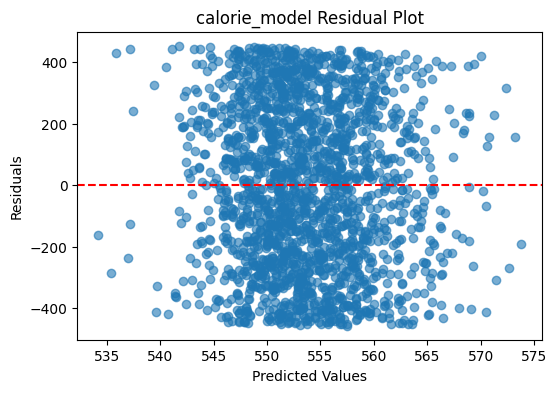

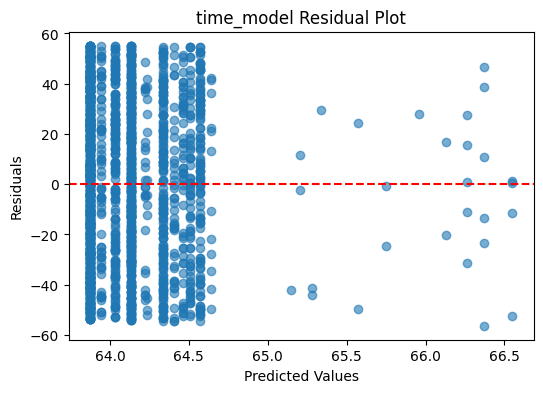

In [20]:
def plot_residuals(model, X_test, y_test, model_name):
    """Plots residuals to visualize errors."""
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} Residual Plot")
    plt.show()

# Apply residual analysis for both models
for model_name, model in models.items():
    X_test = test_df[input_features[model_name]]
    y_test = test_df[output_features[model_name]]
    plot_residuals(model, X_test, y_test, model_name)

## 5. Save assets

In [21]:
Path('../models').mkdir(exist_ok=True)

with open('../models/optimized_models.pkl', 'wb') as output_file:
    pickle.dump(models, output_file)

with open('../models/optimized_hyperparameters.pkl', 'wb') as output_file:
    pickle.dump(optimized_hyperparameters, output_file)